# Task 2: Analysis of an ergodic Markov chain. Calculation of the steady-state vector of Markov chain by Cesàro summation

**Task description**: The probability transaction matrix of an ergodic Markov chain is given.

**Steps for Performing the Task:**
1. Calculate the chain period $d$
2. Find cyclic classes in which the chain is divided
3. Find (approximately) steady-state vector of Markov chain by Cesàro summation

**Student name:** Yan Jingyu

## Solution

I will use Python's Jupyter notebook to complete this task, in which I will use dependency libraries such as numpy and pandas.

### 0. Prepare Data

Prepare my personal Markov chain probability transition matrix, Import the required libraries and read the transition matrix P.

In [1]:
import numpy as np
from numpy.linalg import matrix_power
from math import gcd
from functools import reduce
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=200, threshold=1000, suppress=True, formatter={'float': '{:0.5f}'.format})


def get_my_transition_matrix(xlsx_file, my_name, num_rows=12, use_cols='C:N', ) -> np.ndarray:
    """
    Read my personal transition matrix from an Excel (xlsx) file.
    """
    df = pd.read_excel(xlsx_file)
    row_index = df[df[df.columns[0]] == my_name].index
    if row_index.empty:
        raise FileNotFoundError(
            "transition matrix does not exist, please check the name is correct.")

    region = pd.read_excel(xlsx_file, usecols=use_cols, skiprows=row_index[0] + 1, nrows=num_rows)

    return region.to_numpy()

xlsx_filename = "TaskWorksheets2.xlsx"
my_name = "Yan Jingyu"
P = get_my_transition_matrix(xlsx_filename, my_name)
print(f'My transition matrix P = \n{P}')

My transition matrix P = 
[[0.00000 0.00000 0.12819 0.36008 0.00000 0.00000 0.00000 0.00000 0.15395 0.00000 0.35778 0.00000]
 [0.34321 0.00000 0.00000 0.00000 0.00000 0.65679 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.35969 0.45478 0.00000 0.00000 0.00000 0.18553]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.53366 0.46174 0.00000 0.00000 0.00000 0.00459]
 [0.35442 0.00000 0.00000 0.00000 0.00000 0.64558 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.55971 0.05475 0.00000 0.00000 0.00000 0.00000 0.20515 0.00000 0.18039 0.00000]
 [0.00000 0.29669 0.00000 0.00000 0.49574 0.00000 0.00000 0.00000 0.00000 0.20757 0.00000 0.00000]
 [0.00000 0.60745 0.00000 0.00000 0.36487 0.00000 0.00000 0.00000 0.00000 0.02768 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.31611 0.20304 0.00000 0.00000 0.00000 0.48085]
 [0.39972 0.00000 0.00000 0.00000 0.00000 0.60028 0.00000 0.00000 0.00000 0.00000 0

### 1. Calculate the chain period $d$

My probability transaction matrix has been read into memory and stored using P.

For finding the chain period d and cyclic classes we begin moving from any state of the chain.

Let the state 3 is starting. From the state 7, 8, 12 can be reached; from the states 7, 8, 12, states [2, 5, 10] are reachable. This moving can be listed in the following:
- step.1 -> 3
- step.2 -> 7, 8, 12
- step.3 -> 2, 5, 10
- step.4 -> 1, 6
- step.5 -> 3, 4, 9, 11
- step.6 -> 7, 8, 12
- step.7 -> 2, 5, 10
- step.9 -> 1, 6
- step.10 -> .....

It is obvious that $d$=4 and cyclic classes are $d$=4 and cyclic classes are $C_0=${$7, 8, 12$}, $C_1=${$2, 5, 10$}, $C_2=${$1, 6$}, $C_3=${$3, 4, 9, 11$}

Transitions between classes: $C_0$ -> $C_1$ -> $C_2$ -> $C_3$ -> $C_0$ -> $C_1$ -> ...  

To verify the correctness of the period value obtained, we implement a function for this verification. The function will print out the cyclic classes based on the period.

In [2]:
def compute_chain_period(transition_matrix):
    n = transition_matrix.shape[0]  # Number of states
    periods = []

    for i in range(n):
        state_periods = []
        # Start with the square of the matrix to avoid trivial self-loop
        for j in range(2, n * n):
            # Raise the transition matrix to the j-th power
            matrix_power_j = matrix_power(transition_matrix, j)
            if matrix_power_j[i, i] > 0:
                state_periods.append(j)
                break  # Only need the first occurrence

        # Compute all GCDs for the state i
        if state_periods:
            state_period = reduce(gcd, state_periods)
            periods.append(state_period)

    # Compute the GCD across all states to find the period d
    chain_period = reduce(gcd, periods)
    return chain_period

d = compute_chain_period(P)
assert d == 4
print(f"period d = {d}")

period d = 4


So, I think that the period $d$ of the chain is 4.

### 2. Find cyclic classes in which the chain is divided

From the above calculation process, we have already learned that d=4 and the cyclic classes are $C_0=${$7, 8, 12$}, $C_1=${$2, 5, 10$}, $C_2=${$1, 6$}, $C_3=${$3, 4, 9, 11$}. 

We implement a function to verify whether this is correct. Consider using DFS.

In [3]:
def find_cycles_with_limit(matrix, start_row, loop_n=1):
    """
    Find cycles starting from the given row by following non-zero indices, limited by loop_n.
    """

    def get_nonzero_indices(row):
        """Get all indices with non-zero values in the given row."""
        return [i + 1 for i, value in enumerate(row) if value > 0]  # Convert to 1-indexed

    visited_rows = set()  # Keep track of visited rows to detect a cycle
    cycles = []  # Store the sequences of rows in cycles
    current_row = start_row
    loops_count = 0  # Count the number of complete loops
    period = 0
    while loops_count < loop_n:
        if current_row in visited_rows:
            # If the current row has already been visited, we've completed a loop
            loops_count += 1
            # If we've reached the desired number of loops, break the loop
            if loops_count == loop_n:
                period = len(visited_rows)
                break
            visited_rows.clear()  # Clear visited rows for the next loop

        visited_rows.add(current_row)
        row_indices = get_nonzero_indices(matrix[current_row - 1])  # Get non-zero indices of the current row
        cycles.append(row_indices)  # Add the non-zero indices as a cycle
        if not row_indices:  # If no non-zero indices, break the loop
            break
        current_row = row_indices[0]  # Continue with the first non-zero index

    return cycles, period

start = 3
loop_n = 3
cycles_result, period = find_cycles_with_limit(P, start, loop_n=loop_n)
print(f"Start: {start}")
print(f'When the expected number of loops is {loop_n}, the result is {cycles_result}')

Start: 3
When the expected number of loops is 3, the result is [[7, 8, 12], [2, 5, 10], [1, 6], [3, 4, 9, 11], [7, 8, 12], [2, 5, 10], [1, 6], [3, 4, 9, 11], [7, 8, 12], [2, 5, 10], [1, 6], [3, 4, 9, 11]]


In [4]:
cyclic_classes = cycles_result[:period]
for i, cycle in enumerate(cyclic_classes):
    print(f"C{i} = {cycle}")

C0 = [7, 8, 12]
C1 = [2, 5, 10]
C2 = [1, 6]
C3 = [3, 4, 9, 11]


In [5]:
# Check
combined_set = set()
for sublist in cyclic_classes:
    combined_set.update(sublist)

square_matrix_size = P.shape[0]

assert set(list(range(1, square_matrix_size+1)))
assert len(combined_set) == square_matrix_size

### 3. Find (approximately) steady-state vector of Markov chain by Cesàro summation

The limiting matrix $A$ can be found as the limit $A(t) = \frac{1}{t} \sum_{i=0}^{t-1} P^i $ when $ t \rightarrow \infty $ (summation by Cesàro). The number $ t $ should be enough large.


In [6]:
print(f'My transition matrix P = \n{P}')

My transition matrix P = 
[[0.00000 0.00000 0.12819 0.36008 0.00000 0.00000 0.00000 0.00000 0.15395 0.00000 0.35778 0.00000]
 [0.34321 0.00000 0.00000 0.00000 0.00000 0.65679 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.35969 0.45478 0.00000 0.00000 0.00000 0.18553]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.53366 0.46174 0.00000 0.00000 0.00000 0.00459]
 [0.35442 0.00000 0.00000 0.00000 0.00000 0.64558 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.55971 0.05475 0.00000 0.00000 0.00000 0.00000 0.20515 0.00000 0.18039 0.00000]
 [0.00000 0.29669 0.00000 0.00000 0.49574 0.00000 0.00000 0.00000 0.00000 0.20757 0.00000 0.00000]
 [0.00000 0.60745 0.00000 0.00000 0.36487 0.00000 0.00000 0.00000 0.00000 0.02768 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.31611 0.20304 0.00000 0.00000 0.00000 0.48085]
 [0.39972 0.00000 0.00000 0.00000 0.00000 0.60028 0.00000 0.00000 0.00000 0.00000 0

We have implemented the FindSteadyStateVector class, which employs the Cesàro summation to approximate the steady state vector of a Markov chain.  It iteratively calculates the powers of the transition matrix, averages them, and assesses convergence by comparing the Euclidean distance between successive averages.  As iterations progress, differences between rows should diminish, indicating the approach towards a steady state.

In [7]:
import numpy as np
from numpy.linalg import matrix_power
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=200, threshold=1000, suppress=True, formatter={'float': '{:0.5f}'.format})


class FindSteadyStateVector(object):
    """
    A class to find the limiting matrix or steady state vector of a Markov chain using the Cesàro summation method.
    It takes a transition matrix and computes the Cesàro mean of the matrix up to a specified max power.
    """

    def __init__(self, transaction_matrix: np.ndarray, max_power: int):
        self.P = transaction_matrix.copy()
        self.max_power = max_power
        self.loss_func = self.max_euclidean_distance
        self.loss_from_total_steps = None
        self.A = None

    def fitting(self):
        """
        Executes the Cesàro summation and computes the loss at each step, where the loss is the maximum
        Euclidean distance between the rows of the summation matrix.
        """
        ts = range(1, self.max_power + 1)
        self.loss_from_total_steps = list()
        print("Running Cesàro summation and loss calculation...")
        with tqdm(total=self.max_power, desc='Calculating', unit='step') as pbar:
            for t in ts:
                self.A = self.cesaro_summation(self.P, t)
                loss = self.loss_func(self.A)
                self.loss_from_total_steps.append(loss)
                pbar.update(1)  # Update the progress bar
                pbar.set_postfix(Loss=f"{loss:.6f}")  # Display additional information

        print("Calculation completed.")

    def plot_loss(self):
        """
        Plots the loss over the steps of Cesàro summation to visualize the convergence of the steady state vector.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_from_total_steps, 'b-', label='Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Loss over Cesàro Summation Steps')
        plt.grid(True)
        plt.legend()
        plt.show()

    @staticmethod
    def cesaro_summation(transition_matrix, t):
        """
        Computes the Cesàro summation of the transition matrix up to the power t.
        """
        powers = [matrix_power(transition_matrix, n) for n in range(t)]
        powers_stack = np.stack(powers)
        cesaro_mean = np.mean(powers_stack, axis=0)
        return cesaro_mean

    @staticmethod
    def max_euclidean_distance(matrix):
        """
        Computes the maximum Euclidean distance between any two rows of a matrix.
        """
        # Initialize the maximum distance as zero
        max_dist = 0
        # Get the number of rows in the matrix
        num_rows = matrix.shape[0]

        # Compute the Euclidean distance between each pair of different rows and find the maximum
        for i in range(num_rows):
            for j in range(i + 1, num_rows):  # Only compare different rows to avoid redundant computations
                # Compute the Euclidean distance between row i and row j
                l2_norm = np.linalg.norm(matrix[i] - matrix[j])
                # Update the maximum distance
                max_dist = max(max_dist, l2_norm)

        return max_dist


We will begin the iteration process, setting $t$ to 700, which means that the transition matrix $P$ will be raised to the 700th power. This also entails carrying out 700 iterations and calculating the loss at each step.

In [8]:
# Set t = 700
t = 700
# Instantiating
finder = FindSteadyStateVector(P, t)

# Start iterating
finder.fitting()

Running Cesàro summation and loss calculation...


Calculating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:14<00:00, 46.92step/s, Loss=0.002299]

Calculation completed.


The limiting matrix $A$ for t = 700:

In [9]:
# Print the A
A = finder.A
final_loss = finder.loss_from_total_steps[-1]
print(f"The limiting matrix A({t}) = \n{A}\n")
print(f"The final loss = {final_loss}")

The limiting matrix A(700) = 
[[0.09038 0.09531 0.10093 0.04128 0.11219 0.15962 0.07316 0.10627 0.04666 0.04250 0.06113 0.07056]
 [0.08944 0.09619 0.10133 0.04100 0.11155 0.16056 0.07317 0.10625 0.04671 0.04226 0.06096 0.07058]
 [0.08946 0.09534 0.10217 0.04077 0.11218 0.16054 0.07327 0.10629 0.04644 0.04248 0.06062 0.07044]
 [0.08946 0.09539 0.10075 0.04220 0.11218 0.16054 0.07351 0.10630 0.04644 0.04244 0.06062 0.07018]
 [0.08946 0.09476 0.10133 0.04100 0.11298 0.16054 0.07317 0.10625 0.04671 0.04226 0.06097 0.07058]
 [0.08895 0.09530 0.10154 0.04085 0.11220 0.16105 0.07317 0.10623 0.04673 0.04251 0.06088 0.07059]
 [0.08947 0.09518 0.10132 0.04100 0.11226 0.16053 0.07418 0.10564 0.04671 0.04256 0.06097 0.07018]
 [0.08945 0.09563 0.10133 0.04100 0.11207 0.16055 0.07275 0.10707 0.04671 0.04230 0.06097 0.07018]
 [0.08947 0.09516 0.10074 0.04077 0.11224 0.16053 0.07320 0.10593 0.04787 0.04260 0.06062 0.07087]
 [0.08952 0.09476 0.10130 0.04102 0.11155 0.16048 0.07317 0.10625 0.04670 0.043

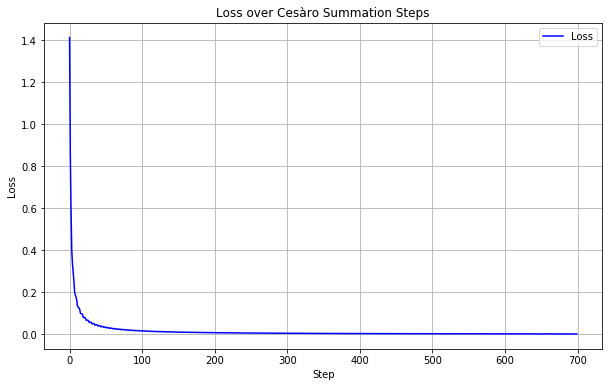

In [10]:
# draw the loss curve
finder.plot_loss()

**Conclusion:** Using the Cesàro summation method to calculate the limit matrix of the Markov chain, we observe a rapid decline in the loss values which then stabilize, indicating that the algorithm has successfully converged to a steady state.